<a href="https://colab.research.google.com/github/Vivegavane/ML_Project/blob/main/Traffic_congestion_prediction_using_GRU_(RNN_model)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title IMPORTING THE DATASET
#Loading Data
data = pd.read_csv('/content/traffic.csv')
data.head()


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
# @title TO CHECK IF THE DATA HAS ANY NULL OR MISSING VALUES
#preprocessing
data.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [ ]:
# @title DROPPING ID COLUMN
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


here we have dropped the ID which is an unnecesary column to have an comparison with the other features

Text(0.5, 0, 'Date')

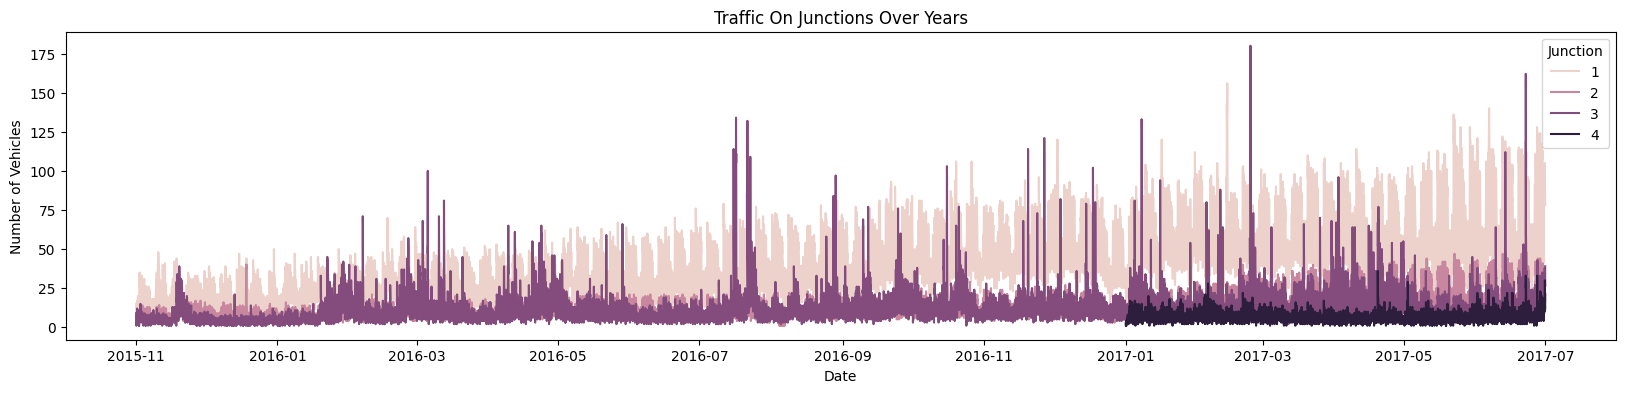

In [ ]:
#df to be used for EDA
df=data.copy()
#Let's plot the Timeseries
plt.figure(figsize=(20,4))
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction")
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")


here in above plotted lineplot we see that the first junction is visibly having an upward trend. The data for the fourth junction is sparse starting only after 2017 Seasonality is not evident from the above plot

In [ ]:
data.describe()

,Junction,Vehicles
count,48120.000000,48120.000000
mean,2.180549,22.791334
std,0.966955,20.750063
min,1.000000,1.000000
25%,1.000000,9.000000
50%,2.000000,15.000000
75%,3.000000,29.000000
max,4.000000,180.000000


In [ ]:
#Exploring more features
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()


,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


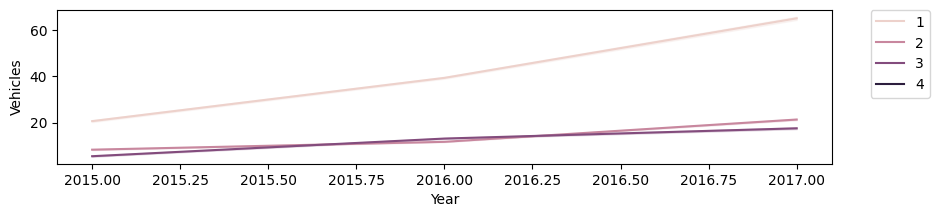

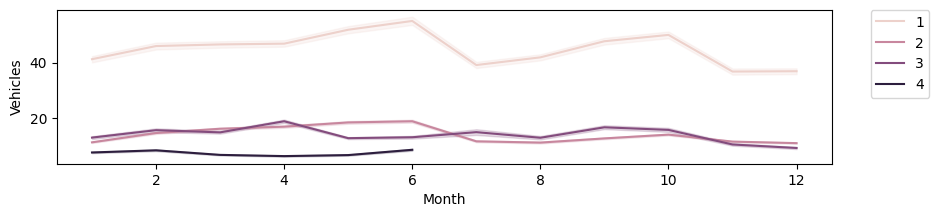

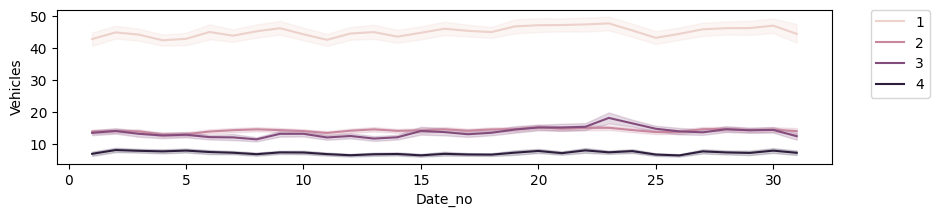

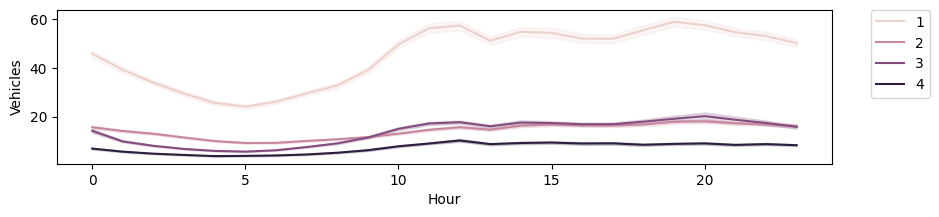

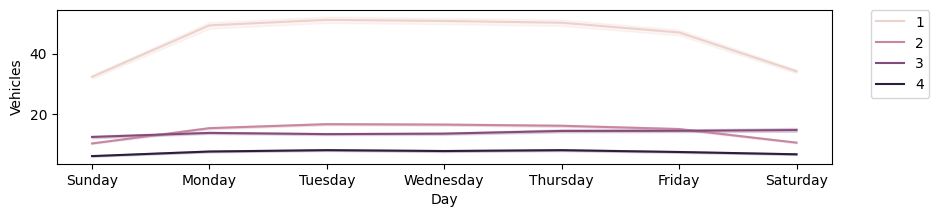

In [ ]:
#Let's plot the Timeseries
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2))
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction" )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


in the above plot we see that all junctions show rise in a yearly tendency if we see the plot based on days , hour and date we can conclude that most vehicles going in 2 ,3 , 4 junctions is most probably due to working days
if we see on  sundays the traffic the no of vehiles are reduced


Text(0.5, 0, 'Date')

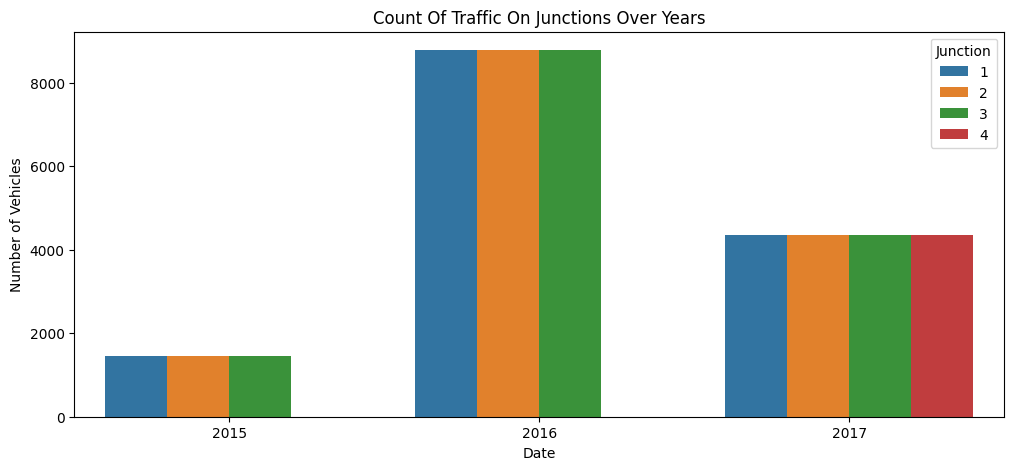

In [ ]:
# @title COUNTPLOT TO REPRESENT THE TRAFFIC IN EACH YEAR BASED UPON THE TOTAL NO OF VEHICLES
plt.figure(figsize=(12,5))
count = sns.countplot(data=df, x =df["Year"], hue="Junction")
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")


the countplot suggest that in 2015 and 2016 here was a gradual increase in the no  of vehicles and in 2017  there was huge decrease due less data


<Axes: >

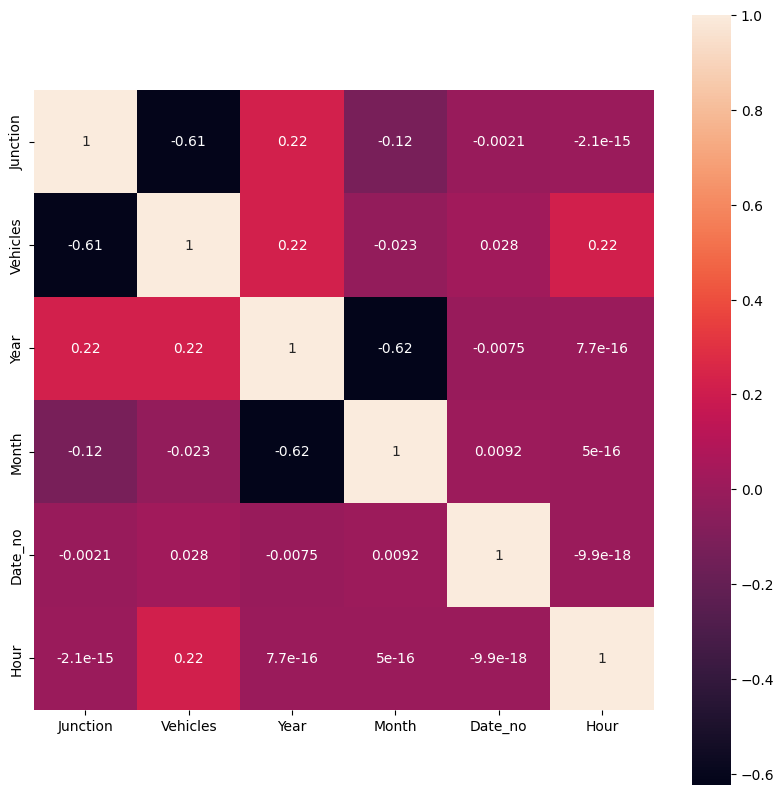

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat,annot=True,square=True, )


here in the correlation confusion matrix for each variables we notice that there is strong relationship for the prexisting features

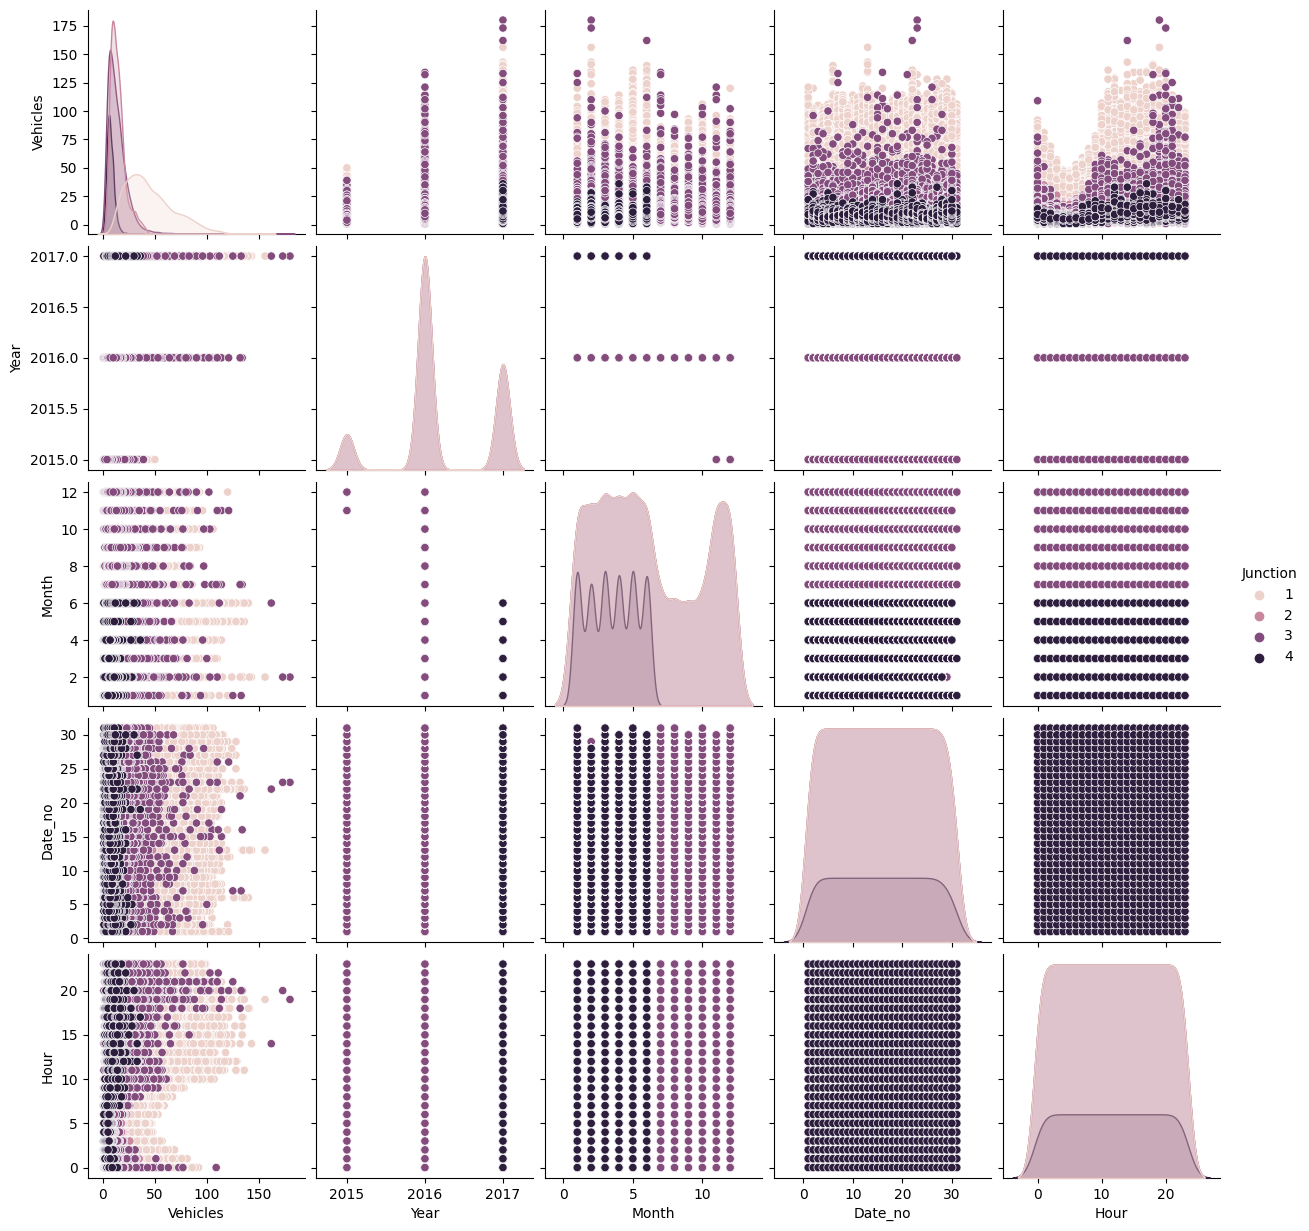

In [ ]:
sns.pairplot(data=df, hue= "Junction")


The annual trend for Junctions 1, 2, and 3 has varying slopes.
The first junction has a stronger weekly seasonality than the other junctions.

In [ ]:
#Pivoting data from junction
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()
df_J


Vehicles                  
Junction                   1     2     3     4
DateTime                                      
2015-11-01 00:00:00     15.0   6.0   9.0   NaN
2015-11-01 01:00:00     13.0   6.0   7.0   NaN
2015-11-01 02:00:00     10.0   5.0   5.0   NaN
2015-11-01 03:00:00      7.0   6.0   1.0   NaN
2015-11-01 04:00:00      9.0   7.0   2.0   NaN
...                      ...   ...   ...   ...
2017-06-30 19:00:00    105.0  34.0  33.0  11.0
2017-06-30 20:00:00     96.0  35.0  31.0  30.0
2017-06-30 21:00:00     90.0  31.0  28.0  16.0
2017-06-30 22:00:00     84.0  29.0  26.0  22.0
2017-06-30 23:00:00     78.0  27.0  39.0  12.0

[14592 rows x 4 columns]

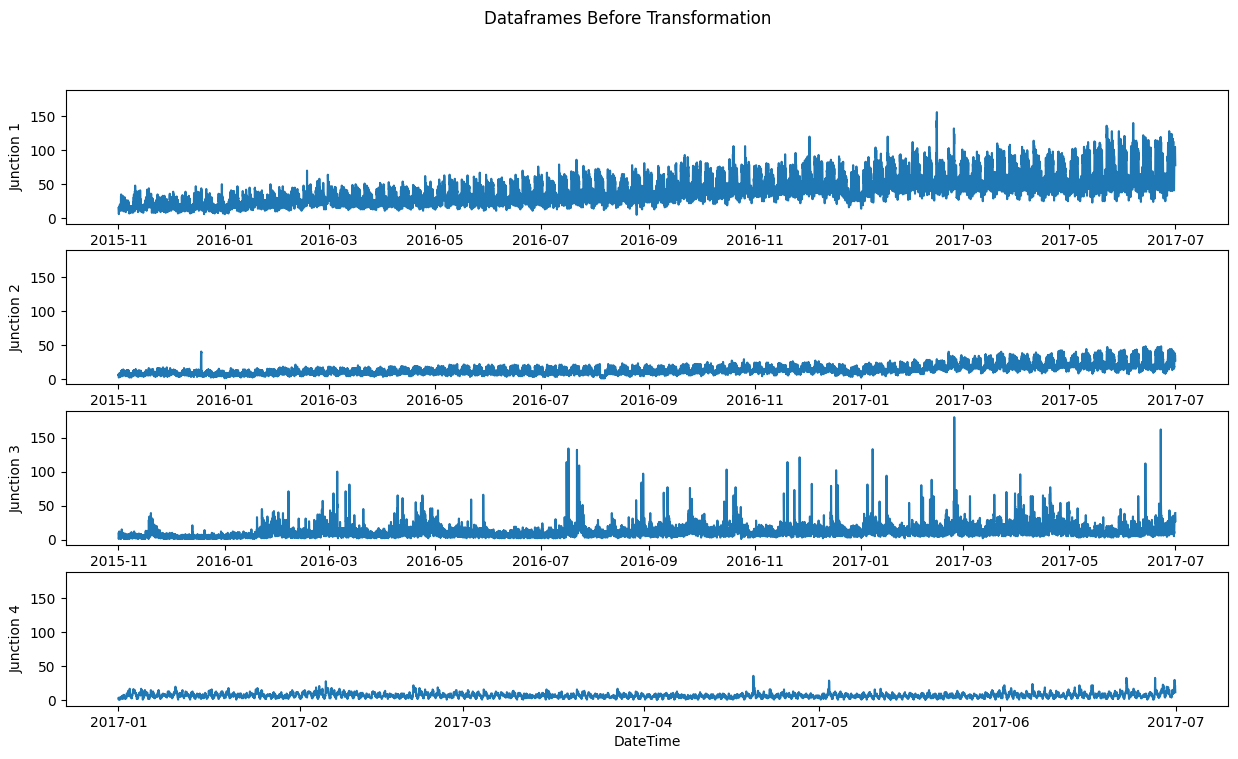

In [ ]:
# @title PLOTTING OF DATASETS OF EACH JUNCTION TO SEE IF THERE A TREND
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1)
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2)
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3)
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4)
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")


For each junction i.e junction 1 and 2 we see that there is an upward trend noticing the weekly seasonality clearly whereas in junction 3 and its lacking a pattern or we can say its constant

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff


here the differencing procedure is done to remove seasonality  there here we have used to difference in weekly numbers for junction 1.
The difference of consecutive days is a preferable option for junction two.
The difference between the hourly numbers will be used for Junctions 3 and 4.

In [ ]:
#Normalizing and Differencing to make the series stationary
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1
df_N1.head()

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4


In [ ]:
df_N1.head()

,Norm,Diff
DateTime,,
2015-11-08 00:00:00,-1.393099,-0.086925
2015-11-08 01:00:00,-1.262712,0.130387
2015-11-08 02:00:00,-1.480024,0.043462
2015-11-08 03:00:00,-1.610412,0.043462
2015-11-08 04:00:00,-1.523487,0.043462


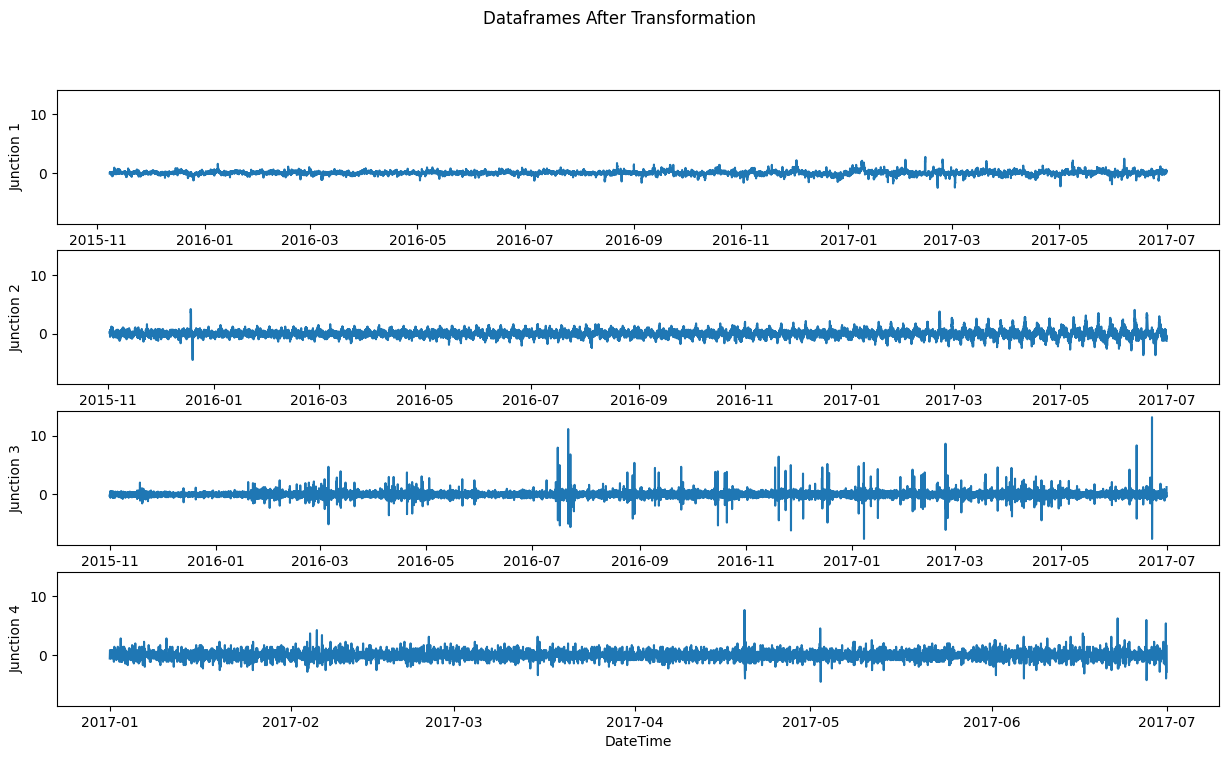

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")


here after transformations by using the above normalising and differencing we see the plot appears to linear

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)


Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
# @title Building the model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming df_N1, df_N2, df_N3, df_N4 are your original dataframes

# Differencing created some NA values, so let's drop them
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

# Splitting the dataset
def Split_data(df):
    training_size = int(len(df) * 0.90)
    data_len = len(df)
    train, test = df.iloc[0:training_size], df.iloc[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

# Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

# Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X, y


# Fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0], test.shape[1], 1))
    return train, test

# Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1=FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2=FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3=FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 =FeatureFixShape(X_trainJ4, X_testJ4)


In [ ]:
X.print(X)

NameError: ignored

In [ ]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU




#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

    #To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test,label="True Value",alpha=0.5 )
    plt.plot(predicted,label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()


In [ ]:
#Predictions For First Junction

# Define your GRU model
def create_GRU_model():
    model = Sequential()
    model.add(GRU(units=64, input_shape=(X_trainJ1.shape[1], X_trainJ1.shape[2])))
    model.add(Dense(1))  # Adjust the output layer as needed
    return model


# Compile the model using the new optimizer syntax
model = create_GRU_model()
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)  # Use momentum instead of decay
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train your model using X_trainJ1 and y_trainJ1

# Make predictions
PredJ1 = model.predict(X_testJ1)



45/45 [==============================] - 1s 6ms/step


here we predict the first junction based on the GRU_model and get the RMSE with respect to pred probability of junction 1

The root mean squared error is 0.30163549600756.


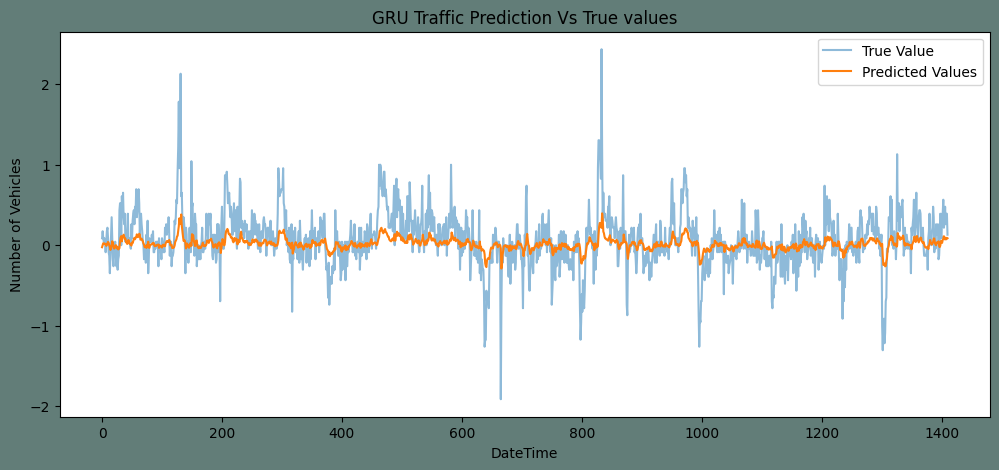

In [ ]:
#Results for J1
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)


here the RMSE  is almost closer to 0 having an accuracy of 93.06

In [ ]:
# Assuming you have calculated the RMSE as rmse and have the range_of_target
range_of_target = max(y_testJ1) - min(y_testJ1)  # Calculate the range of your target variable
accuracy = (range_of_target - RMSE_J1) / range_of_target * 100
print("Accuracy based on RMSE: {:.2f}%".format(accuracy))


Accuracy based on RMSE: 93.06%


In [ ]:
#Predictions For Second Junction

# Define your GRU model
def create_GRU_model():
    model = Sequential()
    model.add(GRU(units=64, input_shape=(X_trainJ2.shape[1], X_trainJ2.shape[2])))
    model.add(Dense(1))  # Adjust the output layer as needed
    return model

# Compile the model using the new optimizer syntax
model = create_GRU_model()
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)  # Use momentum instead of decay
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train your model using X_trainJ2 and y_trainJ2

# Make predictions
PredJ2 = model.predict(X_testJ2)



45/45 [==============================] - 1s 6ms/step


The root mean squared error is 0.9727643505211265.


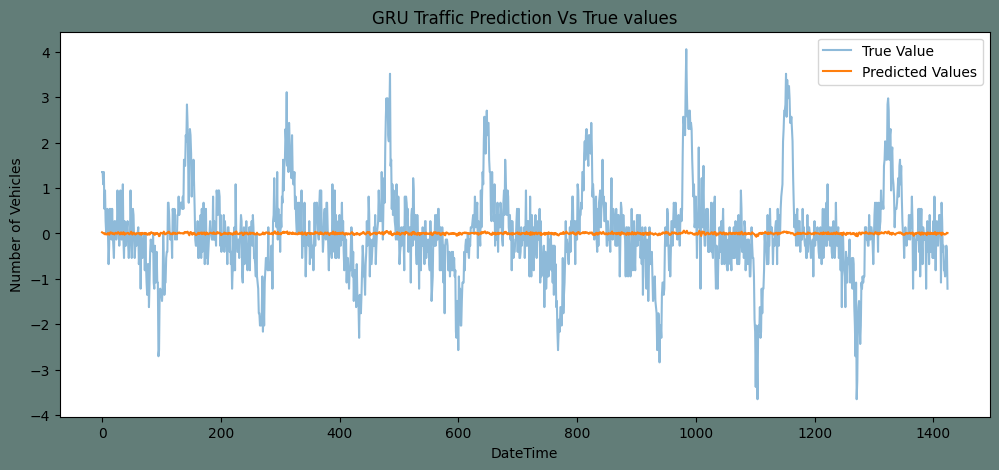

In [ ]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)


In [ ]:
range_of_target = max(y_testJ2) - min(y_testJ2)  # Calculate the range of your target variable
accuracy = (range_of_target - RMSE_J2) / range_of_target * 100
print("Accuracy based on RMSE: {:.2f}%".format(accuracy))

Accuracy based on RMSE: 87.37%


In [ ]:
#Predictions For Third Junction

# Define your GRU model
def create_GRU_model():
    model = Sequential()
    model.add(GRU(units=64, input_shape=(X_trainJ3.shape[1], X_trainJ3.shape[2])))
    model.add(Dense(1))  # Adjust the output layer as needed
    return model

# Compile the model using the new optimizer syntax
model = create_GRU_model()
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)  # Use momentum instead of decay
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train your model using X_trainJ3 and y_trainJ3

# Make predictions
PredJ3 = model.predict(X_testJ3)


45/45 [==============================] - 1s 5ms/step


The root mean squared error is 0.6203688832861055.


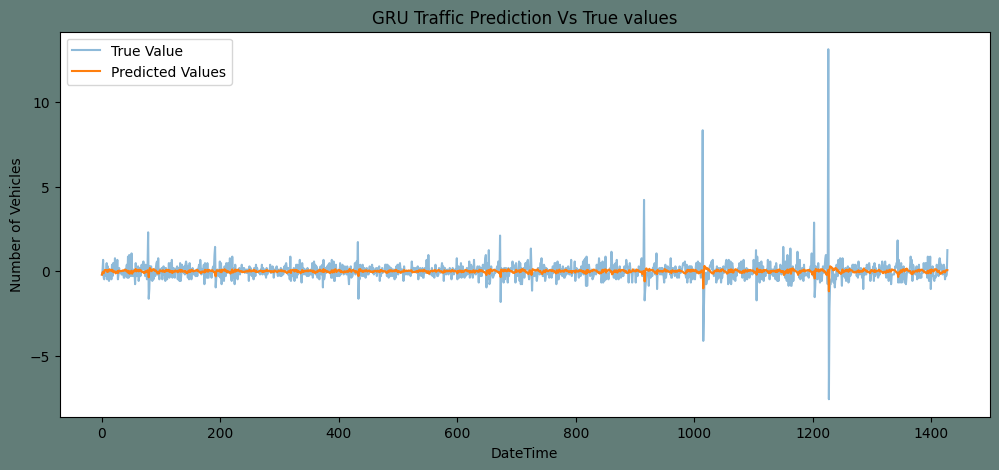

Accuracy based on RMSE: 97.00%


In [ ]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)
range_of_target = max(y_testJ3) - min(y_testJ3)  # Calculate the range of your target variable
accuracy = (range_of_target - RMSE_J3) / range_of_target * 100
print("Accuracy based on RMSE: {:.2f}%".format(accuracy))

In [ ]:
#Predictions For fourth Junction

# Define your GRU model
def create_GRU_model():
    model = Sequential()
    model.add(GRU(units=64, input_shape=(X_trainJ4.shape[1], X_trainJ4.shape[2])))
    model.add(Dense(1))  # Adjust the output layer as needed
    return model

# Compile the model using the new optimizer syntax
model = create_GRU_model()
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)  # Use momentum instead of decay
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train your model using X_trainJ4 and y_trainJ4

# Make predictions
PredJ4 = model.predict(X_testJ4)


13/13 [==============================] - 1s 6ms/step


The root mean squared error is 1.1446114597577801.


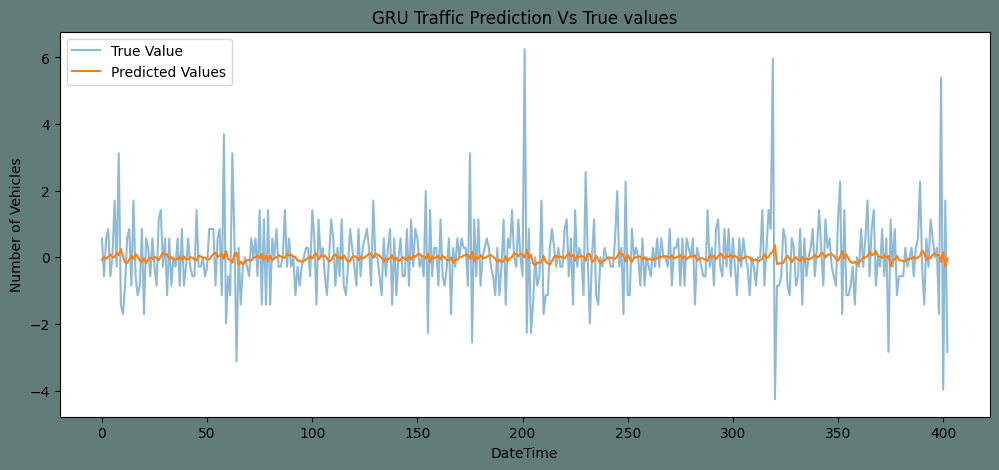

Accuracy based on RMSE: 89.11%


In [ ]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)
range_of_target = max(y_testJ4) - min(y_testJ4)  # Calculate the range of your target variable
accuracy = (range_of_target - RMSE_J4) / range_of_target * 100
print("Accuracy based on RMSE: {:.2f}%".format(accuracy))

In [ ]:
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]
list_of_tuples = list(zip(Junctions, RMSE))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results.style.background_gradient(cmap="Pastel1")

,Junction,RMSE
0,Junction1,0.301635
1,Junction2,0.972764
2,Junction3,0.620369
3,Junction4,1.144611


In [ ]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1)
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

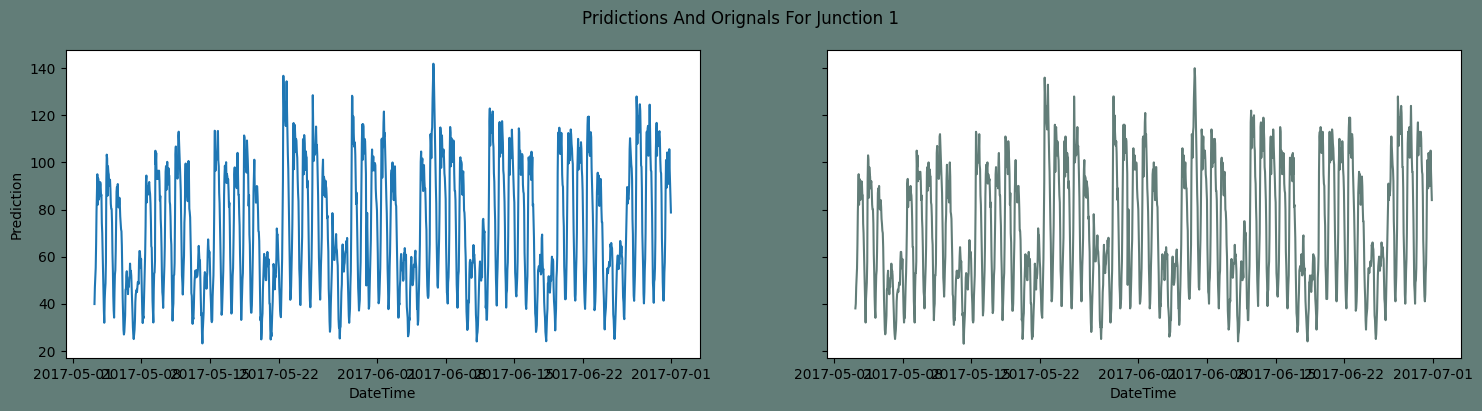

In [ ]:
# Ensure that you have the same length for slicing and matching indices
# Assuming you want to take the last 1411 predictions and align with the index
recover1 = df_N1.Norm[-1411:].to_frame()  # Make a copy to avoid index issues
recover1["Pred"] = PredJ1

# Continue with the rest of your code...

Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

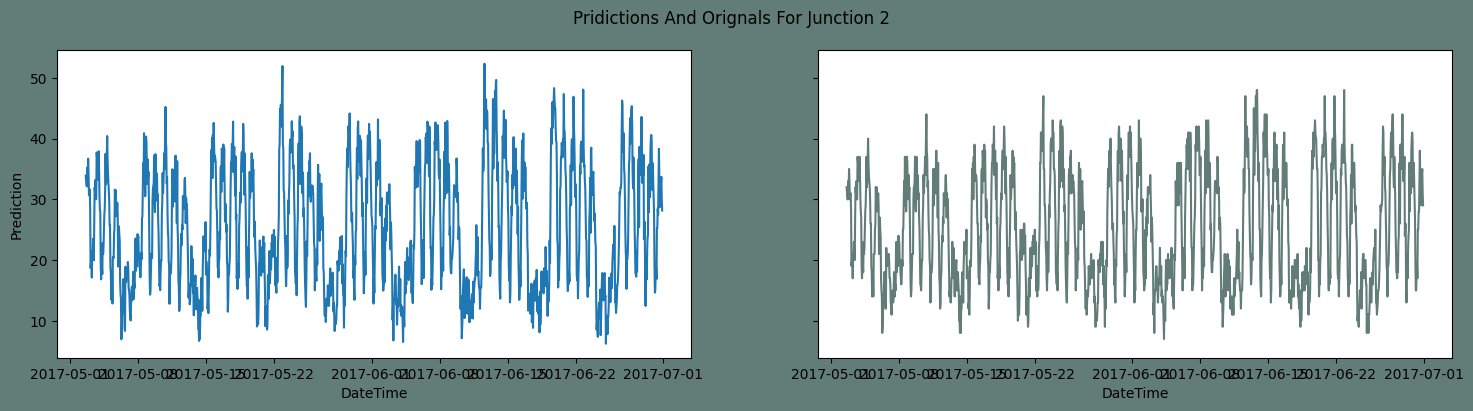

In [ ]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)


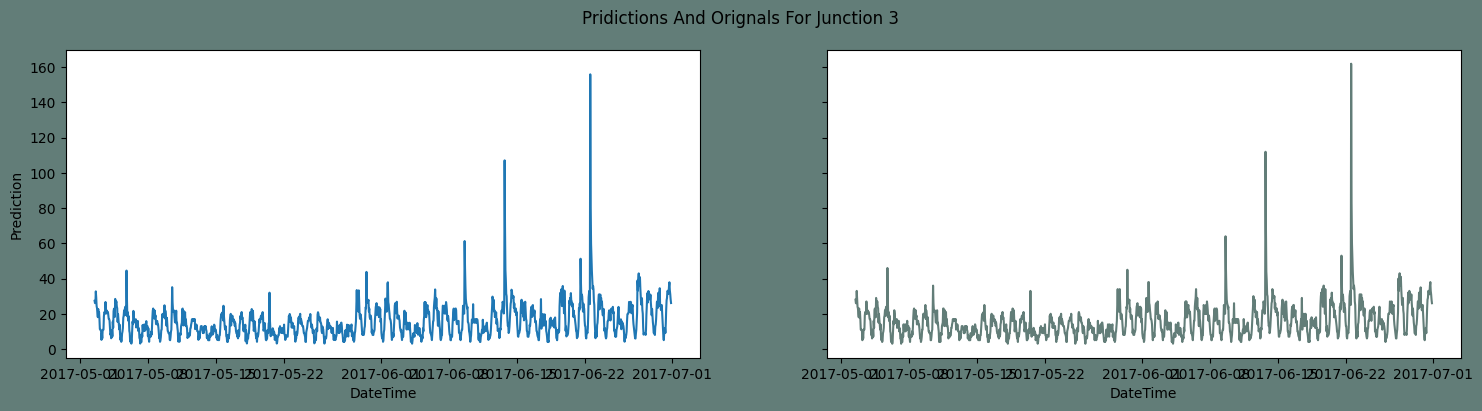

In [ ]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)


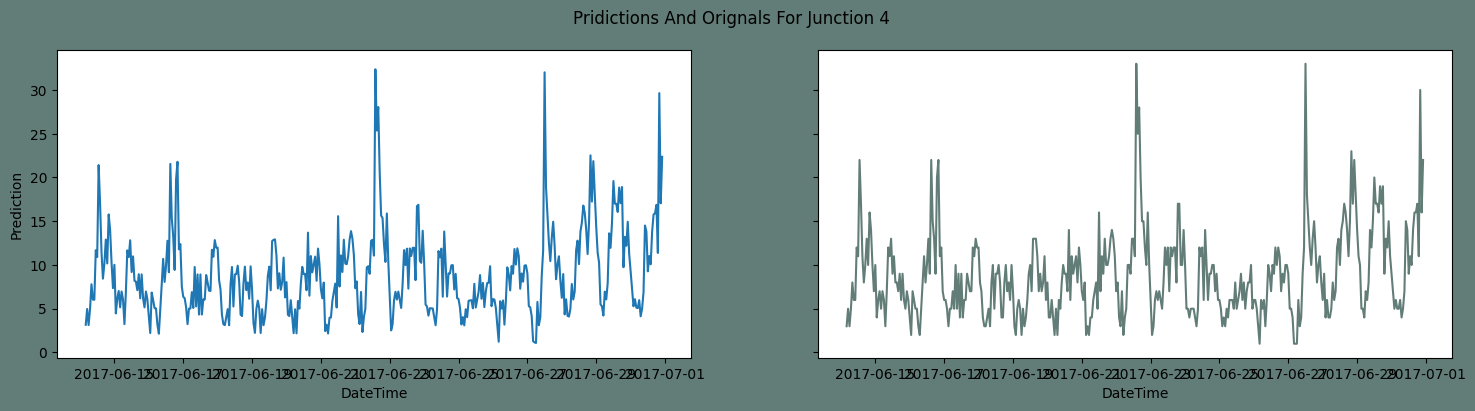

In [ ]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)


### at four crossroads To create a stationary time series, we employed a normalization and differentiating transform. We used a different strategy for each intersection to make it stationary because the junctions vary in trends and seasonality. We used the root mean squared error as the model's assessment measure. Also, we placed the predictions next to the initial test results. Conclusions are drawn from the data analysis:

Compared to junctions two and three, junction one is seeing a faster increase in the number of cars. Junction Four has very little data. Therefore, we can't draw any conclusions from it.

The Junction one's traffic has a stronger weekly seasonality as well as hourly seasonality. In comparison, other junctions are significantly linear.